In [2]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import KFold
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import sys
import foolbox, time

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB *  of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 3)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

(18065, 28, 28)
(18065,)


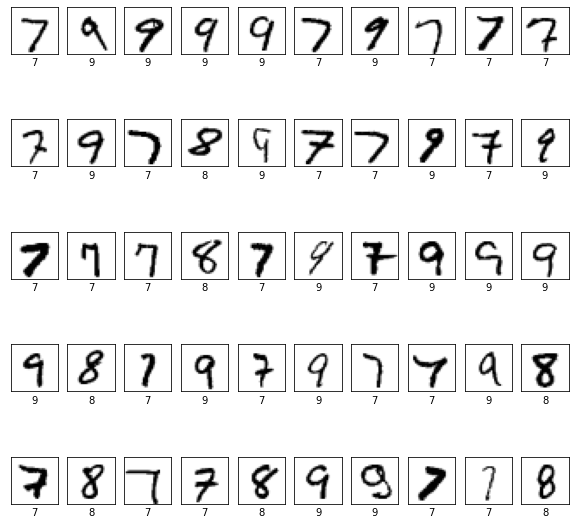

In [4]:
#Filter all Images with classes from 7-9 from dataset for part2
truth_array2 = (y_train==7) | (y_train==8) | (y_train==9)
truth_array2_test = (y_test==7) | (y_test==8) | (y_test==9)

x_teil2 = x_train[truth_array2]
dt = np.dtype(np.uint8)
y_teil2=np.array([], dtype=dt)


for value in y_train:
    if value > 6:
        y_teil2 = np.append(y_teil2, value)

print(x_teil2.shape)
print(y_teil2.shape)

x_test2 = x_test[truth_array2_test]
dt = np.dtype(np.uint8)
y_test2=np.array([], dtype=dt)

for value in y_test:
    if value > 6:
        y_test2 = np.append(y_test2, value)

#Normalize pixel values to be between 0 and 1
x_teil2 = x_teil2 / 255.0 -0.5
x_test2 = x_test2 / 255.0 -0.5

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py

plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test2[i], cmap=plt.cm.binary)
    plt.xlabel(y_test2[i])
plt.show()

y_teil2 = y_teil2.reshape(y_teil2.shape[0], 1)
x_teil2 = x_teil2.reshape(x_teil2.shape[0], x_teil2.shape[1], x_teil2.shape[2], 1)

y_test2 = y_test2.reshape(y_test2.shape[0], 1)
x_test2 = x_test2.reshape(x_test2.shape[0], x_test2.shape[1], x_test2.shape[2], 1)

#inputs and targets for kFold training set
inputs = x_teil2
targets = y_teil2

In [ ]:
#Quelle
#https://scikit-learn.org/stable/modules/cross_validation.html#k-fold
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    #Create and Train the Model for MNIST 7-9
    #Quelle
    #Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
    #https://www.tensorflow.org/guide/keras/sequential_model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),   
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),  
      tf.keras.layers.Dense(200,activation='relu'),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.Dense(200,activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    #LearningRate WarmUp -> kein Erfolg-> schriftlich festhalten dass wir neu trainiert haben    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #model.summary()

    #Quelle
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    
    checkpoint_filepath = f'tmp/checkpoint{fold_no}'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    #Quelle
    #https://www.tensorflow.org/guide/keras/train_and_evaluate
    
    history = model.fit(
        inputs[train], targets[train],
        epochs=50,
        batch_size=128,
        validation_data=(inputs[test], targets[test]),
        callbacks=[model_checkpoint_callback]
    )

    #model.load_weights(checkpoint_filepath)
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(model.metrics_names)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Save the entire model
    !mkdir -p saved_models_mnist_kfold
    model.save(f'saved_models_mnist_kfold/base_model_mnist7-9_{fold_no}')
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
fig1, plotacc = plt.subplots()
plotacc.set_xlabel('CNN MNIST', rotation=90)
plotacc.set_ylabel('Training Accuracy in (%)')
print(acc_per_fold)
plt.show()

In [18]:
#Quelle
#https://www.tensorflow.org/tutorials/images/transfer_learning

def display_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(title)
    plt.xlabel('epoch')
    plt.show()

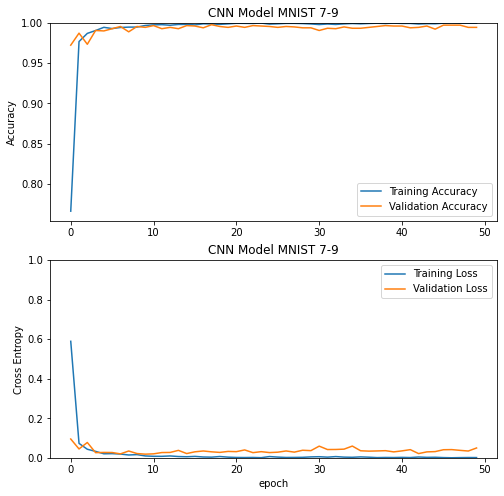

In [19]:
# Display training curve 
display_history(history, "CNN Model MNIST 7-9")

7


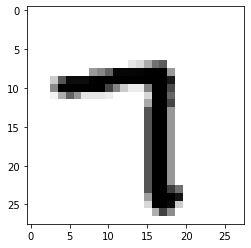

In [22]:
#Predict random image
y=model.predict(x_test2)
print(np.argmax(y[1500]))
plt.imshow(x_test2[1500], cmap=plt.cm.binary)

In [ ]:
import pandas as pd
# Evaluate all 10 models
accuracy = list()
for i in range(1,11):
    model = tf.keras.models.load_model(f'saved_models_mnist_kfold/base_model_mnist7-9_{i}')
    model.load_weights(f'tmp/checkpoint{i}')

    loss, acc = model.evaluate(x_test2, y_test2, verbose=2)
    print('Accuracy: {:5.2f}%'.format(100 * acc))
    accuracy.append(acc)
    print(model.predict(x_test2).shape)
    
    df = pd.DataFrame(accuracy, columns=['Scores'])
    df.to_excel('accuracy.xlsx', sheet_name='kfold', index=False)

In [7]:
#Import Foolbox Packages
#Quelle
#https://foolbox.readthedocs.io/en/stable/
from foolbox import TensorFlowModel, accuracy, samples, Model, utils, attacks, plot
from foolbox.attacks import LinfPGD, LinfDeepFoolAttack
import pandas as pd

In [5]:
model = tf.keras.models.load_model(f'saved_models_mnist_kfold/base_model_mnist7-9_4')
model.load_weights(f'tmp/checkpoint4')

In [8]:
#Run an attack with foolbox
#Quelle
#https://github.com/bethgelab/foolbox
preprocessing = dict()
bounds = (-0.5, 0.5)
fmodel = TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((-0.5, 0.5))

attack_labels = tf.convert_to_tensor(y_test2, dtype='int64')
attack_labels = tf.reshape(attack_labels, 3011)
attack_images = tf.convert_to_tensor(x_test2, dtype='float32')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [13]:
#Quelle
#https://www.kaggle.com/josephvm/generating-adversarial-examples-with-foolbox
predictions = model.predict(attack_images)
orig_predictions = np.argmax(predictions, axis = 1)
print(f"Clean Accuracy:  {np.mean(orig_predictions == attack_labels) * 100:.2f} %") # Accuracy of original images
already_correct = np.sum(orig_predictions != attack_labels) # keep track of how many were already correct

Clean Accuracy:  98.94 %


In [14]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
#PGD40 mit 20 Restarts, Table1
import eagerpy as ep
attack_images = ep.astensor(attack_images)
attack_labels = ep.astensor(attack_labels)
attack = attacks.LinfPGD()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        1.0,
    ]

success_rate = np.zeros(len(epsilons))

loop_array = np.array_split(np.arange(attack_images.shape[0]), 10)

for i , idx in enumerate(loop_array): 
    restarts = 20

    truth_array = np.zeros(shape=(len(epsilons),len(idx)), dtype=bool)
    print('Batch: ', i)
    for k in range(restarts):
        print('Restart: ', k)
        raw, clipped, is_adv = attack(fmodel, attack_images[idx], attack_labels[idx], epsilons=epsilons)
        arr = is_adv.numpy()
        truth_array = truth_array | arr
    
    success_rate += np.sum(truth_array, axis=1)
#print(attack_images.shape)
#print('Success Rate:', success_rate / attack_images.shape[0])
    
print("Attack finished!")

Batch:  0
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  1
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  2
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  3
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16

In [15]:
print('Success Rate:', success_rate / attack_images.shape[0])
df = pd.DataFrame((success_rate / attack_images.shape[0]), columns=['Success_rate'])
df.to_excel('attack_success_rate_test.xlsx', sheet_name='attack', index=False)

Success Rate: [0.0106277  0.01095981 0.01095981 0.01095981 0.01129193 0.01129193
 0.01129193 0.01129193 0.01328462 0.20724012 0.52573896 0.75788774
 0.96446363 1.         1.         1.        ]


In [78]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
import eagerpy as ep
attack_images = ep.astensor(attack_images)
attack_labels = ep.astensor(attack_labels)
attack = attacks.LinfPGD()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        1.0,
    ]
raw, clipped, is_adv = attack(fmodel, attack_images, attack_labels, epsilons=1.0)
df = pd.DataFrame(is_adv.numpy())
df.to_excel('test_is_adv.xlsx', sheet_name='attack', index=True)
print(np.sum(is_adv.numpy()/len(attack_images)))
print("Attack finished!")

0.9940219196280308
Attack finished!


robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 0.66 %
  Linf norm ≤ 0.0002: 0.46 %
---------------------------------------------------------


ValueError: x and y must have same first dimension, but have shapes (16,) and (2,)

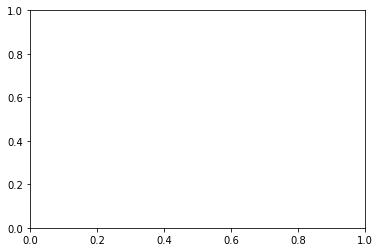

In [73]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
accuracy = list()
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.2f} %")
    accuracy.append(acc.item() * 100)
print("---------------------------------------------------------")

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py
#https://github.com/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb
plt.plot(epsilons, robust_accuracy.numpy() * 100)
#plt.plot(epsilon, label='Epsilon')
#plt.legend(loc='upper right')
plt.ylabel('Accuracy in (%)')
plt.title('Robust Accuracy')
plt.xlabel('Epsilon')
plt.show()

#Quelle
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('robust_accuracy.png', dpi=300, bbox_inches='tight')

#Quelle
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
df = pd.DataFrame(accuracy)

#Quelle
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html
df.to_excel('robust_accuracy_mnist_small.xlsx', sheet_name='attack', index=False)

In [69]:
print('Versionsinformationen der Module:')
print(sys.executable)
print(sys.version)
print(sys.version_info)
!conda --version
!python --version
print('Tensorflow: ' + tf.__version__)
print('Tensorflow Datasets: ' + tfds.__version__)
print('Eagerpy: ' + ep.__version__)
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__)
print('Foolbox: ' + foolbox.__version__)
print('Pandas: ' + pd.__version__)

Versionsinformationen der Module:
/home/fabian/anaconda3/envs/tf-gpu2/bin/python
3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
conda 4.10.1
Python 3.8.5
Tensorflow: 2.4.1
Tensorflow Datasets: 3.1.0
Eagerpy: 0.29.0
Numpy: 1.20.2
Matplotlib: 3.4.1
Foolbox: 3.3.1
Pandas: 1.2.4
